# Applied AI Summative Assessment

## Data preprocessing / cleaning

In [1]:
#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from scipy.stats import uniform, randint
import math

#filepath - NOTE EMPTIED TO REMOVE PERSONAL IDENTIFYING INFO
filepath = ''

#load the 2 datasets then check head
dataset1 = pd.read_csv(filepath+'GCB2022v27_MtCO2_flat.csv')
dataset2 = pd.read_csv(filepath+'uk_renewable_energy.csv')
print("######### CHECK DATA LOADED #########")
print("############# Dataset 1 #############")
print("######### Number of rows and columns: ", dataset1.shape)
print(dataset1.head())
print("############# Dataset 2 #############")
print("######### Number of rows and columns: ", dataset2.shape)
print(dataset2.head())


#add UK country code code to dataset2 for merging
dataset2['ISO 3166-1 alpha-3'] = 'GBR'

#merge datasets based on Year and country code then check head
merged_data = pd.merge(dataset1, dataset2, on=['Year', 'ISO 3166-1 alpha-3'])
print("######### CHECK DATA MERGED #########")
print("######### Number of rows and columns: ", merged_data.shape)
print(merged_data.head())


#DATA CLEANING
#drop rows where all columns (except 'Year' and 'Country') are NaN or zero
merged_data.dropna(how='all', subset=merged_data.columns.difference(['Year', 'ISO 3166-1 alpha-3']), inplace=True)

#country is redundant, drop it
merged_data.drop('Country', axis=1, inplace=True)

#perform interpolation on other NaNs
merged_data.interpolate(method='linear', limit_direction='forward', inplace=True)

#give columns more meaningful names (useful for charting later on)
merged_data = merged_data.rename(columns={'Total': 'Total co2', 'Per Capita': 'co2 Per Capita'})

#check cleaned data
print("######### CHECK DATA MERGED #########")
print("######### Number of rows and columns: ", merged_data.shape)
print(merged_data.describe())

#one-hot encoding on nominal attributes
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

nominal_features = ['ISO 3166-1 alpha-3']
OH_cols = pd.DataFrame(encoder.fit_transform(merged_data[nominal_features]))
OH_cols.index = merged_data.index
num_merged_data = merged_data.drop(nominal_features, axis=1)
OH_merged_data = pd.concat([num_merged_data, OH_cols], axis=1)

print("##### CHECK DATA ONEHOT ENCODED #####")
print("######### Number of rows and columns: ", OH_merged_data.shape)
print(OH_merged_data.head())

######### CHECK DATA LOADED #########
############# Dataset 1 #############
######### Number of rows and columns:  (63104, 11)
       Country ISO 3166-1 alpha-3  Year  Total  Coal  Oil  Gas  Cement  \
0  Afghanistan                AFG  1750    0.0   NaN  NaN  NaN     NaN   
1  Afghanistan                AFG  1751    0.0   NaN  NaN  NaN     NaN   
2  Afghanistan                AFG  1752    0.0   NaN  NaN  NaN     NaN   
3  Afghanistan                AFG  1753    0.0   NaN  NaN  NaN     NaN   
4  Afghanistan                AFG  1754    0.0   NaN  NaN  NaN     NaN   

   Flaring  Other  Per Capita  
0      NaN    NaN         NaN  
1      NaN    NaN         NaN  
2      NaN    NaN         NaN  
3      NaN    NaN         NaN  
4      NaN    NaN         NaN  
############# Dataset 2 #############
######### Number of rows and columns:  (31, 21)
   Year  Energy from renewable & waste sources  \
0  1990                                  1.647   
1  1991                                  1.634   


/Users/danielcrompton/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


## Exploratory data analysis

######### DATA STAT SUMMARY #########
              Year   Total co2        Coal         Oil         Gas     Cement  \
count    31.000000   31.000000   31.000000   31.000000   31.000000  31.000000   
mean   2005.000000  518.041552  138.786960  191.634453  172.975408   5.362257   
std       9.092121   80.539806   60.252929   19.912040   29.578310   1.078940   
min    1990.000000  326.263199   22.809405  143.980921  113.517625   3.721209   
25%    1997.500000  473.662292  116.291609  173.508699  151.836950   4.378654   
50%    2005.000000  561.649574  147.662298  196.160270  168.235546   5.843838   
75%    2012.500000  572.524272  157.786213  206.338618  202.291035   6.200959   
max    2020.000000  609.412673  253.622509  219.163179  211.734175   7.295263   

         Flaring      Other  co2 Per Capita  \
count  31.000000  31.000000       31.000000   
mean    5.652666   3.629807        8.545309   
std     1.344786   0.512838        1.696815   
min     3.442599   2.710492        4.865281 

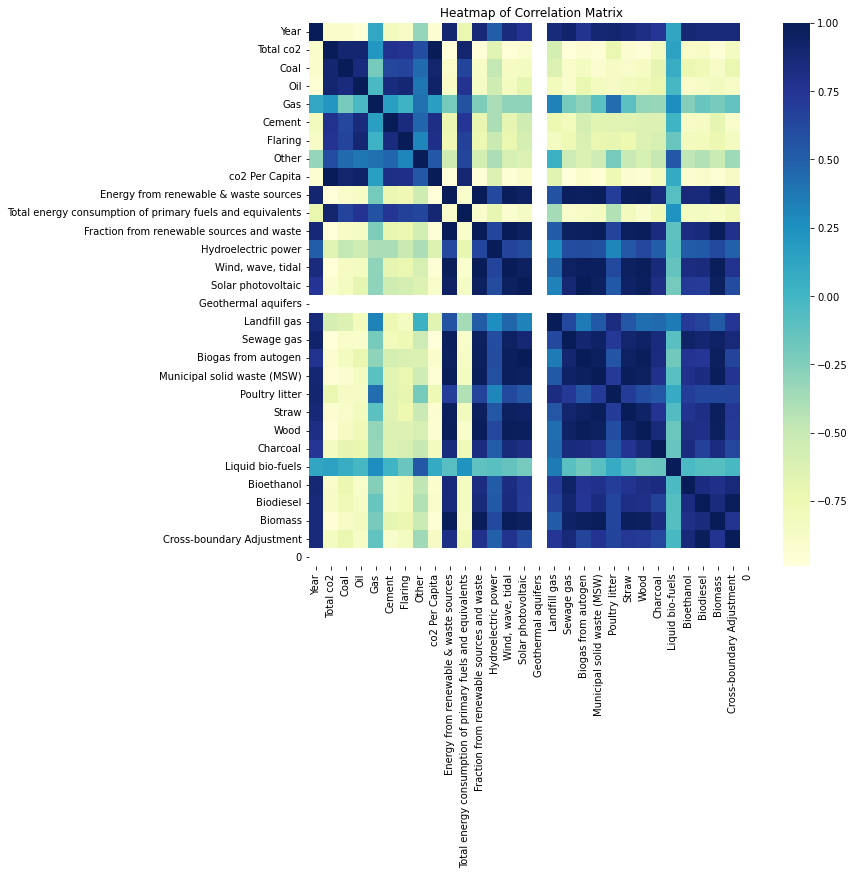

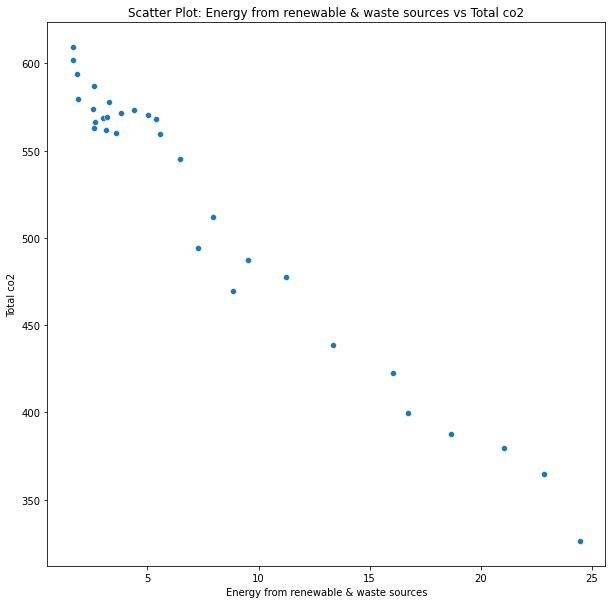

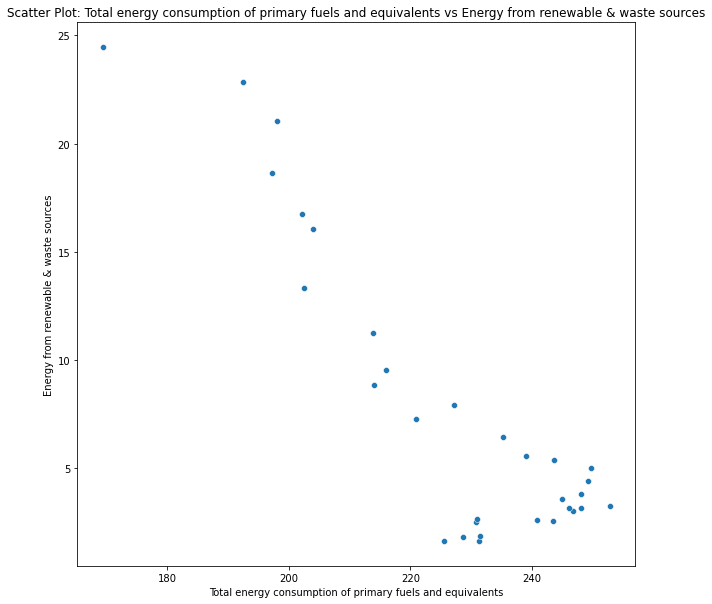

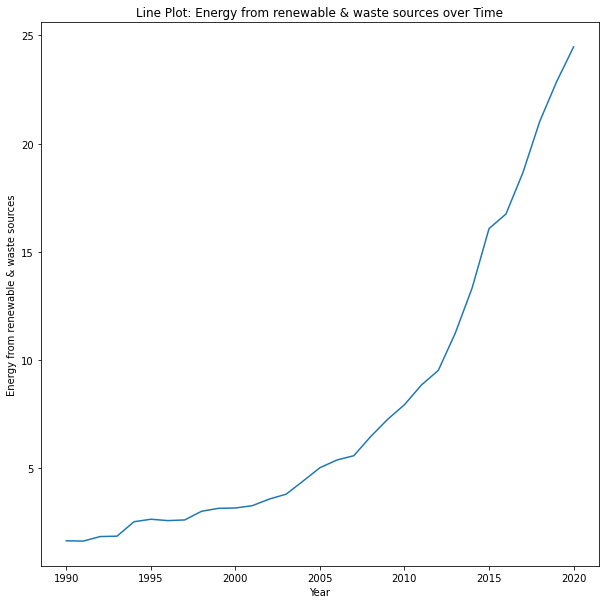

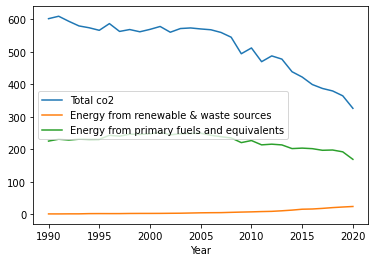

In [2]:
#check the statistical summary of the data
print("######### DATA STAT SUMMARY #########")
print(OH_merged_data.describe())

#check which variables have the strongest correlations
correlation = OH_merged_data.corr()
plt.figure(figsize=(10,10)) # Change the size if needed
sns.heatmap(correlation, xticklabels=correlation.columns, yticklabels=correlation.columns, cmap="YlGnBu")
plt.title('Heatmap of Correlation Matrix')

#visual charts for better understanding of the data

#scatter plots
feature1 = 'Energy from renewable & waste sources'
feature2 = 'Total co2'
plt.figure(figsize=(10,10)) 
sns.scatterplot(data=OH_merged_data, x=feature1, y=feature2)
plt.title('Scatter Plot: {} vs {}'.format(feature1, feature2))

feature1 = 'Total energy consumption of primary fuels and equivalents'
feature2 = 'Energy from renewable & waste sources'
plt.figure(figsize=(10,10)) 
sns.scatterplot(data=OH_merged_data, x=feature1, y=feature2)
plt.title('Scatter Plot: {} vs {}'.format(feature1, feature2))

#line plot
time_variable = 'Year'
feature1 = 'Energy from renewable & waste sources'
plt.figure(figsize=(10,10)) 
sns.lineplot(data=OH_merged_data, x=time_variable, y=feature1)
plt.title('Line Plot: {} over Time'.format(feature1))
plt.show()

#multiple line plot showing total co2 v use of renewables over time
time_variable = OH_merged_data['Year']
feature1 = OH_merged_data['Total co2']
feature2 = OH_merged_data['Energy from renewable & waste sources']
feature3 = OH_merged_data['Total energy consumption of primary fuels and equivalents']
plt.plot(time_variable, feature1, label='Total co2')
plt.plot(time_variable, feature2, label='Energy from renewable & waste sources')
plt.plot(time_variable, feature3, label='Energy from primary fuels and equivalents')
plt.xlabel('Year')
plt.legend()
plt.show()

## Split data for testing

In [3]:
#data split
#rename variable/features columns (tensorflow doesn't like spaces or special chars)
OH_merged_data = OH_merged_data.rename(columns={
    'Total co2': 'Total_co2',
    'Energy from renewable & waste sources': 'Energy_Renewable_Waste_Sources',
    'Total energy consumption of primary fuels and equivalents': 'Total_Energy_Consumption_Primary_Fuels'
})

#target variable (total co2)
y = OH_merged_data['Total_co2']  

#set features
X = OH_merged_data[['Year', 'Energy_Renewable_Waste_Sources', 'Total_Energy_Consumption_Primary_Fuels']]

#split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#CHECKS
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

print("First few rows of x_train:")
print(X_train.head())

print("First few rows of y_train:")
print(y_train.head())

print("First few rows of x_test:")
print(X_test.head())

print("First few rows of y_test:")
print(y_test.head())


Shape of X_train: (24, 3)
Shape of X_test: (7, 3)
Shape of y_train: (24,)
Shape of y_test: (7,)
First few rows of x_train:
    Year  Energy_Renewable_Waste_Sources  \
24  2014                          13.332   
12  2002                           3.575   
0   1990                           1.647   
4   1994                           2.528   
16  2006                           5.380   

    Total_Energy_Consumption_Primary_Fuels  
24                                 202.499  
12                                 244.980  
0                                  225.532  
4                                  230.739  
16                                 243.557  
First few rows of y_train:
24    438.807081
12    560.273200
0     601.945078
4     574.016890
16    567.845659
Name: Total_co2, dtype: float64
First few rows of x_test:
    Year  Energy_Renewable_Waste_Sources  \
27  2017                          18.656   
15  2005                           5.026   
23  2013                          11.238

## Build the initial model

In [4]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Initialize the model
dt_model = DecisionTreeRegressor(random_state=0)
rf_model = RandomForestRegressor(random_state=0)

# Fit the model
dt_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

# Predict on the testing data
dt_y_pred = dt_model.predict(X_test)
rf_y_pred = rf_model.predict(X_test)

# Output and keep track of the model's performance metrics
dt_MAE = mean_absolute_error(y_test, dt_y_pred)
dt_MSE = mean_squared_error(y_test, dt_y_pred)
dt_RMSE = np.sqrt(dt_MSE)

rf_MAE = mean_absolute_error(y_test, rf_y_pred)
rf_MSE = mean_squared_error(y_test, rf_y_pred)
rf_RMSE = np.sqrt(rf_MSE)

print("Full Model Performance Metrics")
#average of differences between predicted and actual (0 indicates no error)
print(f"dt Mean Absolute Error (MAE): {dt_MAE}")
print(f"dt Mean Squared Error (MSE): {dt_MSE}")
print(f"dt Root Mean Squared Error (RMSE): {dt_RMSE}")
print(f"rf Mean Absolute Error (MAE): {rf_MAE}")
print(f"rf Mean Squared Error (MSE): {rf_MSE}")
print(f"rf Root Mean Squared Error (RMSE): {rf_RMSE}")

# Perform K-Fold CV on dt and rf
dt_scores_orig = cross_val_score(dt_model, X_train, y_train, cv=10)
rf_scores_orig = cross_val_score(rf_model, X_train, y_train, cv=10)

# Calculate mean & standard deviation of scores
dt_mean_score_orig = dt_scores_orig.mean()
dt_std_score_orig = dt_scores_orig.std()
rf_mean_score_orig = rf_scores_orig.mean()
rf_std_score_orig = rf_scores_orig.std()

print(f"Original Decision tree CV mean Score: {dt_mean_score_orig}")
print(f"Original Decision tree CV standard deviation: {dt_std_score_orig}")

print(f"Original Random forest CV mean Score: {rf_mean_score_orig}")
print(f"Original Random forest CV standard deviation: {rf_std_score_orig}")

Full Model Performance Metrics
dt Mean Absolute Error (MAE): 6.882051285714291
dt Mean Squared Error (MSE): 73.20335895046607
dt Root Mean Squared Error (RMSE): 8.555896151220283
rf Mean Absolute Error (MAE): 5.113070747142785
rf Mean Squared Error (MSE): 40.872573890636396
rf Root Mean Squared Error (RMSE): 6.393166186690003
Original Decision tree CV mean Score: -5.673179811808198
Original Decision tree CV standard deviation: 12.94590233015136
Original Random forest CV mean Score: -1.8801886976271018
Original Random forest CV standard deviation: 5.8538356778275755


## Feature selection

In [5]:
from tpot import TPOTRegressor

#initialize the model
#note: more generations / larger population size, 
#= longer runtime + better chance of finding a highly-performing pipeline
tpot = TPOTRegressor(generations=10, population_size=50, offspring_size=None, 
                     mutation_rate=0.9, crossover_rate=0.1,
                     scoring='neg_mean_squared_error', cv=5,
                     subsample=1.0, n_jobs=1, max_time_mins=None, max_eval_time_mins=5,
                     random_state=42, config_dict=None, 
                     warm_start=False,
                     early_stop=None, verbosity=2)

#fit the model
tpot.fit(X_train, y_train)

#export pipeline
tpot.export('tpot_pipeline.py')

#predict on testing data
y_pred = tpot.predict(X_test)

#output & keep track of model's perf. metrics
MAE = mean_absolute_error(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
RMSE = np.sqrt(MSE)

print("Full Model Performance Metrics")
print(f"Mean Absolute Error (MAE): {MAE}")
print(f"Mean Squared Error (MSE): {MSE}")
print(f"Root Mean Squared Error (RMSE): {RMSE}")


Optimization Progress:   0%|          | 0/550 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -139.12215833792922

Generation 2 - Current best internal CV score: -135.82431574951704

Generation 3 - Current best internal CV score: -135.82431574951704

Generation 4 - Current best internal CV score: -134.11929813086485

Generation 5 - Current best internal CV score: -134.11929813086485

Generation 6 - Current best internal CV score: -134.11929813086485

Generation 7 - Current best internal CV score: -109.23307668820951

Generation 8 - Current best internal CV score: -109.23307668820951

Generation 9 - Current best internal CV score: -109.23307668820951

Generation 10 - Current best internal CV score: -100.61518568436802

Best pipeline: RidgeCV(DecisionTreeRegressor(GradientBoostingRegressor(input_matrix, alpha=0.85, learning_rate=0.01, loss=quantile, max_depth=3, max_features=0.9500000000000001, min_samples_leaf=2, min_samples_split=16, n_estimators=100, subsample=0.8500000000000001), max_depth=9, min_samples_leaf=7, min_samples_spli

/Users/danielcrompton/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


## Hyperparameter tuning

In [6]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error

# define parameter grid for DecisionTreeRegressor
dt_param_grid = {
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': [1.0, 'sqrt', 'log2']
}

# define parameter grid for RandomForestRegressor
rf_param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': [1.0, 'sqrt', 'log2']
}

# create base models
dt = DecisionTreeRegressor(random_state=0)
rf = RandomForestRegressor(random_state=0)

# instantiate grid search models
grid_search_dt = GridSearchCV(estimator = dt, param_grid = dt_param_grid, cv = 5, n_jobs = -1, verbose = 2)
grid_search_rf = GridSearchCV(estimator = rf, param_grid = rf_param_grid, cv = 5, n_jobs = -1, verbose = 2)

# fit grid search to data
grid_search_dt.fit(X_train, y_train)
grid_search_rf.fit(X_train, y_train)

# train models on dataset with optimized parameters
dt_model_best_optimized = grid_search_dt.best_estimator_
rf_model_best_optimized = grid_search_rf.best_estimator_

# predict on testing data
y_pred_best_optimized_dt = dt_model_best_optimized.predict(X_test)
y_pred_best_optimized_rf = rf_model_best_optimized.predict(X_test)

# calculate performance metrics
MAE_best_optimized_dt = mean_absolute_error(y_test, y_pred_best_optimized_dt)
MSE_best_optimized_dt = mean_squared_error(y_test, y_pred_best_optimized_dt)
RMSE_best_optimized_dt = np.sqrt(MSE_best_optimized_dt)

MAE_best_optimized_rf = mean_absolute_error(y_test, y_pred_best_optimized_rf)
MSE_best_optimized_rf = mean_squared_error(y_test, y_pred_best_optimized_rf)
RMSE_best_optimized_rf = np.sqrt(MSE_best_optimized_rf)

print("Model Performance Metrics After Hyperparameter Tuning")

print("Decision Tree Regressor")
print(f"Mean Absolute Error (MAE): {MAE_best_optimized_dt}")
print(f"Mean Squared Error (MSE): {MSE_best_optimized_dt}")
print(f"Root Mean Squared Error (RMSE): {RMSE_best_optimized_dt}")

print("\nRandom Forest Regressor")
print(f"Mean Absolute Error (MAE): {MAE_best_optimized_rf}")
print(f"Mean Squared Error (MSE): {MSE_best_optimized_rf}")
print(f"Root Mean Squared Error (RMSE): {RMSE_best_optimized_rf}")


Fitting 5 folds for each of 810 candidates, totalling 4050 fits
[CV] END criterion=squared_error, max_depth=None, max_features=1.0, min_samples_leaf=1, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=None, max_features=1.0, min_samples_leaf=1, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=None, max_features=1.0, min_samples_leaf=1, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=None, max_features=1.0, min_samples_leaf=1, min_samples_split=10, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=None, max_features=1.0, min_samples_leaf=1, min_samples_split=10, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=None, max_features=1.0, min_samples_leaf=1, min_samples_split=10, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=None, max_features=1.0, m

[CV] END criterion=squared_error, max_depth=None, max_features=1.0, min_samples_leaf=5, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=None, max_features=1.0, min_samples_leaf=5, min_samples_split=10, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=None, max_features=1.0, min_samples_leaf=5, min_samples_split=10, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=None, max_features=1.0, min_samples_leaf=5, min_samples_split=10, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=None, max_features=1.0, min_samples_leaf=5, min_samples_split=10, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, splitter=random; total ti

[CV] END criterion=squared_error, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, splitter=random; total time=   0.0s
[C

[CV] END criterion=absolute_error, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, splitter=random; total time= 

[CV] END criterion=absolute_error, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, splitter=best; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, splitter=best; total time=   0.0s

[CV] END criterion=absolute_error, max_depth=5, max_features=1.0, min_samples_leaf=1, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=5, max_features=1.0, min_samples_leaf=1, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=5, max_features=1.0, min_samples_leaf=1, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=5, max_features=1.0, min_samples_leaf=1, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=5, max_features=1.0, min_samples_leaf=1, min_samples_split=5, splitter=random; total time=   0.0s
[CV]

[CV] END criterion=absolute_error, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=5, splitter=best; total time=   

[CV] END criterion=absolute_error, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=10, splitter=random; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=10, splitter=random; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=10, splitter=random; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=10, splitter=random; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, splitter=best; total time=  

[CV] END criterion=absolute_error, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, splitter=best; total time= 

[CV] END criterion=absolute_error, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=10, splitter=best; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=10, splitter=best; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=10, splitter=best; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=10, splitter=random; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=10, splitter=random; total t

[CV] END criterion=absolute_error, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=10, splitter=best; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=10, splitter=best; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, splitter=best; total time=   0.

[CV] END criterion=squared_error, max_depth=None, max_features=1.0, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=None, max_features=1.0, min_samples_leaf=5, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=squared_error, max_depth=None, max_features=1.0, min_samples_leaf=5, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END criterion=squared_error, max_depth=None, max_features=1.0, min_samples_leaf=5, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=None, max_features=1.0, min_samples_leaf=5, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=None, max_features=1.0, min_samples_leaf=5, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END criterion=absolute_error, max_depth=None, max_features=1.0, min_samples_leaf=2, min_samples_split=10, splitter=best;

[CV] END criterion=squared_error, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, splitter=best; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=20, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=20, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=20, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=20, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=20, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, splitter=best; total time= 

[CV] END criterion=absolute_error, max_depth=10, max_features=1.0, min_samples_leaf=1, min_samples_split=10, splitter=random; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=10, max_features=1.0, min_samples_leaf=2, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=10, max_features=1.0, min_samples_leaf=2, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=10, max_features=1.0, min_samples_leaf=2, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=10, max_features=1.0, min_samples_leaf=2, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=10, max_features=1.0, min_samples_leaf=2, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=10, max_features=1.0, min_samples_leaf=2, min_samples_split=2, splitter=random; total time=   0.0s
[

[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=   

[CV] END criterion=absolute_error, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=10, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=None, max_features=1.0, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END criterion=squared_error, max_depth=None, max_features=1.0, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=None, max_features=1.0, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=squared_error, max_depth=None, max_features=1.0, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END criterion=squared_error, max_depth=None, max_features=1.0, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END criterion=squared_error, max_depth=None, max_features=1.0, min_samples_leaf=1, min_samples_split=5, n_estimators=200; to

[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END criterion=squared_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1

[CV] END criterion=squared_error, max_depth=None, max_features=1.0, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=None, max_features=1.0, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.1s
[CV] END criterion=squared_error, max_depth=None, max_features=1.0, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=None, max_features=1.0, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=None, max_features=1.0, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=None, max_features=1.0, min_samples_leaf=5, min_samples_split=10, n_estimators=200; total time=   0.1s
[CV] END criterion=squared_error, max_depth=None, max_features=1.0, min_samples_leaf=5, min_samples_split=10, n_estima

[CV] END criterion=squared_error, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END criterion=squared_error, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=squared_error, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=squared_error, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimato

[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.

[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=10; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=50; total time=   0.0s

[CV] END criterion=squared_error, max_depth=15, max_features=1.0, min_samples_leaf=5, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END criterion=squared_error, max_depth=15, max_features=1.0, min_samples_leaf=5, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END criterion=squared_error, max_depth=15, max_features=1.0, min_samples_leaf=5, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END criterion=squared_error, max_depth=15, max_features=1.0, min_samples_leaf=5, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END criterion=squared_error, max_depth=15, max_features=1.0, min_samples_leaf=5, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END criterion=squared_error, max_depth=15, max_features=1.0, min_samples_leaf=5, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END criterion=squared_error, max_depth=15, max_features=1.0, min_samples_leaf=5, min_samples_split=10, n_estimators=200; total time

[CV] END criterion=squared_error, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END criterion=squared_error, max_depth=15, max_features=1.0, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END criterion=squared_error, max_depth=15, max_features=1.0, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END criterion=squared_error, max_depth=15, max_features=1.0, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=15, max_features=1.0, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total 

[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=

[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=10; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=10; total time=   0.0s
[CV] END criterion=squared_error, max_depth=10, max_features=1.0, min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END criterion=squared_error, max_depth=10, max_features=1.0, min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END criterion=squared_error, max_depth=10, max_features=1.0, min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END criterion=squared_error, max_depth=10, max_features=1.0, min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END criterion=squared_error, max_depth=10, max_features=1.0, min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   0.0s

[CV] END criterion=squared_error, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END criterion=squared_error, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END criterion=squared_error, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END criterion=squared_error, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END criterion=squared_error, max_depth=15, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END criterion=squared_error, max_depth=15, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END criterion=squared_error, max_depth=15, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=100; tot

[CV] END criterion=squared_error, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END criterion=squared_error, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END criterion=squared_error, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END criterion=squared_error, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END criterion=squared_error, max_depth=15, max_features=1.0, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.1s
[CV] END criterion=squared_error, max_depth=15, max_features=1.0, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.2s
[CV] END criterion=squared_error, max_depth=15, max_features=1.0, min_samples_leaf=1, min_samples_split=10, n_estimators=200; tota

[CV] END criterion=squared_error, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END criterion=squared_error, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=squared_error, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=squared_error, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END criterion=squared_error, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END criterion=squared_error, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END criterion=squared_error, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time

[CV] END criterion=squared_error, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END criterion=squared_error, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=squared_error, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=15, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=10; total time=   0.0s
[CV] END criterion=squared_error, max_depth=15, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=10; total time=   0.0s
[CV] END criterion=squared_error, max_depth=15, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=10; total ti

[CV] END criterion=squared_error, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.2s
[CV] END criterion=squared_error, max_depth=15, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=squared_error, max_depth=15, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END criterion=squared_error, max_depth=15, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=15, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=15, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=15, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total

[CV] END criterion=squared_error, max_depth=20, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=10; total time=   0.0s
[CV] END criterion=squared_error, max_depth=20, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=squared_error, max_depth=20, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=squared_error, max_depth=20, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END criterion=squared_error, max_depth=20, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=squared_error, max_depth=20, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=squared_error, max_depth=20, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=100; total time

[CV] END criterion=friedman_mse, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END criterion=friedman_mse, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END criterion=friedman_mse, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END criterion=friedman_mse, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=10; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=10; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=10; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=10; to

[CV] END criterion=friedman_mse, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END criterion=friedman_mse, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.2s
[CV] END criterion=friedman_mse, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.2s
[CV] END criterion=friedman_mse, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators

[CV] END criterion=squared_error, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.2s
[CV] END criterion=friedman_mse, max_depth=None, max_features=1.0, min_samples_leaf=1, min_samples_split=5, n_estimators=10; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=None, max_features=1.0, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=None, max_features=1.0, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=None, max_features=1.0, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total

[CV] END criterion=friedman_mse, max_depth=None, max_features=1.0, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.2s
[CV] END criterion=friedman_mse, max_depth=None, max_features=1.0, min_samples_leaf=5, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=friedman_mse, max_depth=None, max_features=1.0, min_samples_leaf=5, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=friedman_mse, max_depth=None, max_features=1.0, min_samples_leaf=5, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=friedman_mse, max_depth=None, max_features=1.0, min_samples_leaf=5, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=friedman_mse, max_depth=None, max_features=1.0, min_samples_leaf=5, min_samples_split=5, n_estimators=10; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=None, max_features=1.0, min_samples_leaf=5, min_samples_split=5, n_estimators=10; total

[CV] END criterion=squared_error, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END criterion=squared_error, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END criterion=squared_error, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END criterion=squared_error, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END criterion=squared_error, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END criterion=squared_error, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=50; tot

[CV] END criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=10; total time=   0.0s

[CV] END criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.2s

[CV] END criterion=friedman_mse, max_depth=None, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END criterion=friedman_mse, max_depth=None, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END criterion=friedman_mse, max_depth=None, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END criterion=friedman_mse, max_depth=None, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END criterion=friedman_mse, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.2s
[CV] END criterion=friedman_mse, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.2s
[CV] END criterion=friedman_mse, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators

[CV] END criterion=friedman_mse, max_depth=5, max_features=1.0, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END criterion=friedman_mse, max_depth=5, max_features=1.0, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=10; total time=   0.0s

[CV] END criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=50; total time=  

[CV] END criterion=friedman_mse, max_depth=10, max_features=1.0, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=friedman_mse, max_depth=10, max_features=1.0, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=friedman_mse, max_depth=10, max_features=1.0, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=friedman_mse, max_depth=10, max_features=1.0, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=friedman_mse, max_depth=10, max_features=1.0, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=friedman_mse, max_depth=10, max_features=1.0, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=friedman_mse, max_depth=10, max_features=1.0, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.2s

[CV] END criterion=friedman_mse, max_depth=10, max_features=1.0, min_samples_leaf=5, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=10, max_features=1.0, min_samples_leaf=5, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=10, max_features=1.0, min_samples_leaf=5, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=10, max_features=1.0, min_samples_leaf=5, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=10, max_features=1.0, min_samples_leaf=5, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=10, max_features=1.0, min_samples_leaf=5, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=10, max_features=1.0, min_samples_leaf=5, min_samples_split=5, n_estimators=10; total time=   0.0s
[CV] E

[CV] END criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END criterion=friedman_mse, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END criterion=friedman_mse, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END criterion=friedman_mse, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END criterion=friedman_mse, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; tota

[CV] END criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.2s
[CV] END criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.

[CV] END criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=100; total time=   0.1s
[

[CV] END criterion=friedman_mse, max_depth=15, max_features=1.0, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END criterion=friedman_mse, max_depth=15, max_features=1.0, min_samples_leaf=5, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=15, max_features=1.0, min_samples_leaf=5, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=15, max_features=1.0, min_samples_leaf=5, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END criterion=friedman_mse, max_depth=15, max_features=1.0, min_samples_leaf=5, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END criterion=friedman_mse, max_depth=15, max_features=1.0, min_samples_leaf=5, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=15, max_features=1.0, min_samples_leaf=5, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] 

[CV] END criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time

[CV] END criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=15, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=20, max_features=1.0, min_samples_leaf=1, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=20, max_features=1.0, min_samples_leaf=1, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=20, max_features=1.0, min_samples_leaf=1, min_samples_split=10, n_estimators=10; total time=   0.0s

[CV] END criterion=absolute_error, max_depth=None, max_features=1.0, min_samples_leaf=5, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END criterion=absolute_error, max_depth=None, max_features=1.0, min_samples_leaf=5, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END criterion=absolute_error, max_depth=None, max_features=1.0, min_samples_leaf=5, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END criterion=absolute_error, max_depth=None, max_features=1.0, min_samples_leaf=5, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END criterion=friedman_mse, max_depth=15, max_features=1.0, min_samples_leaf=1, min_samples_split=5, n_estimators=10; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=15, max_features=1.0, min_samples_leaf=1, min_samples_split=5, n_estimators=10; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=15, max_features=1.0, min_samples_leaf=1, min_samples_split=5, n_estimators=10; total

[CV] END criterion=absolute_error, max_depth=None, max_features=1.0, min_samples_leaf=1, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=10; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=50; total time=   

[CV] END criterion=friedman_mse, max_depth=20, max_features=1.0, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=friedman_mse, max_depth=20, max_features=1.0, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=friedman_mse, max_depth=20, max_features=1.0, min_samples_leaf=2, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=20, max_features=1.0, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=20, max_features=1.0, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=20, max_features=1.0, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=20, max_features=1.0, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.0s

[CV] END criterion=friedman_mse, max_depth=20, max_features=1.0, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=20, max_features=1.0, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=20, max_features=1.0, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=20, max_features=1.0, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=20, max_features=1.0, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=20, max_features=1.0, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=friedman_mse, max_depth=20, max_features=1.0, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV]

[CV] END criterion=absolute_error, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=10; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=10; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=10; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=10; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END criterion=absolute_error, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END criterion=absolute_error, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estim

[CV] END criterion=absolute_error, max_depth=None, max_features=1.0, min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=None, max_features=1.0, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END criterion=absolute_error, max_depth=None, max_features=1.0, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=None, max_features=1.0, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=None, max_features=1.0, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END criterion=absolute_error, max_depth=None, max_features=1.0, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END criterion=absolute_error, max_depth=None, max_features=1.0, min_samples_leaf=2, min_samples_split=5, n_estimators

[CV] END criterion=absolute_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END criterion=absolute_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=None, max_features=1.0, min_samples_leaf=5, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=None, max_features=1.0, min_samples_leaf=5, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=None, max_features=1.0, min_samples_leaf=5, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=None, max_features=1.0, min_samples_leaf=5, min_samples_split=10, n_estimators=10;

[CV] END criterion=friedman_mse, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.2s
[CV] END criterion=absolute_error, max_depth=None, max_features=1.0, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END criterion=absolute_error, max_depth=None, max_features=1.0, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END criterion=absolute_error, max_depth=None, max_features=1.0, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=absolute_error, max_depth=None, max_features=1.0, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=absolute_error, max_depth=None, max_features=1.0, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=absolute_error, max_depth=None, max_features=1.0, min_samples_leaf=2, min_samples_split=2, n_estimators

[CV] END criterion=absolute_error, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END criterion=absolute_error, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END criterion=absolute_error, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END criterion=absolute_error, max_depth=None, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END criterion=absolute_error, max_depth=None, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=None, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END criterion=absolute_error, max_depth=None, max_features=sqrt, min_samples_leaf=5, min_samples_split=10,

[CV] END criterion=absolute_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=absolute_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=absolute_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=absolute_error, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=absolute_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END criterion=absolute_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END criterion=absolute_error, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=100; total 

[CV] END criterion=absolute_error, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.2s
[CV] END criterion=absolute_error, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.2s
[CV] END criterion=absolute_error, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.2s
[CV] END criterion=absolute_error, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END criterion=absolute_error, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END criterion=absolute_error, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=absolute_error, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=1

[CV] END criterion=absolute_error, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END criterion=absolute_error, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.2s
[CV] END criterion=absolute_error, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.2s
[CV] END criterion=absolute_error, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.2s
[CV] END criterion=absolute_error, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=200; 

[CV] END criterion=absolute_error, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=absolute_error, max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=absolute_error, max_depth=10, max_features=1.0, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END criterion=absolute_error, max_depth=10, max_features=1.0, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END criterion=absolute_error, max_depth=10, max_features=1.0, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END criterion=absolute_error, max_depth=10, max_features=1.0, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END criterion=absolute_error, max_depth=10, max_features=1.0, min_samples_leaf=1, min_samples_split=10, n_estimators=10; tota

[CV] END criterion=absolute_error, max_depth=15, max_features=1.0, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END criterion=absolute_error, max_depth=15, max_features=1.0, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=absolute_error, max_depth=15, max_features=1.0, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=absolute_error, max_depth=15, max_features=1.0, min_samples_leaf=5, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=15, max_features=1.0, min_samples_leaf=5, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=15, max_features=1.0, min_samples_leaf=5, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=15, max_features=1.0, min_samples_leaf=5, min_samples_split=2, n_estimators=10; total tim

[CV] END criterion=absolute_error, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END criterion=absolute_error, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END criterion=absolute_error, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END criterion=absolute_error, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END criterion=absolute_error, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END criterion=absolute_error, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.2s
[CV] END criterion=absolute_error, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimat

[CV] END criterion=absolute_error, max_depth=15, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=absolute_error, max_depth=15, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=absolute_error, max_depth=15, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=absolute_error, max_depth=20, max_features=1.0, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END criterion=absolute_error, max_depth=20, max_features=1.0, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END criterion=absolute_error, max_depth=20, max_features=1.0, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END criterion=absolute_error, max_depth=20, max_features=1.0, min_samples_leaf=1, min_samples_split=5, n_estimators=100; tot

[CV] END criterion=absolute_error, max_depth=20, max_features=1.0, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=20, max_features=1.0, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END criterion=absolute_error, max_depth=20, max_features=1.0, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END criterion=absolute_error, max_depth=20, max_features=1.0, min_samples_leaf=5, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=20, max_features=1.0, min_samples_leaf=5, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END criterion=absolute_error, max_depth=20, max_features=1.0, min_samples_leaf=5, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END criterion=absolute_error, max_depth=20, max_features=1.0, min_samples_leaf=5, min_samples_split=10, n_estimators=50; total t

[CV] END criterion=absolute_error, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=absolute_error, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=absolute_error, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=absolute_error, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=absolute_error, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=10; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=10; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=10; 

[CV] END criterion=poisson, max_depth=None, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=poisson, max_depth=None, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=poisson, max_depth=None, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=poisson, max_depth=None, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=poisson, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END criterion=poisson, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END criterion=absolute_error, max_depth=20, max_features=1.0, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] E

[CV] END criterion=absolute_error, max_depth=15, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END criterion=absolute_error, max_depth=20, max_features=1.0, min_samples_leaf=2, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=20, max_features=1.0, min_samples_leaf=2, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=20, max_features=1.0, min_samples_leaf=2, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=20, max_features=1.0, min_samples_leaf=2, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=20, max_features=1.0, min_samples_leaf=2, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=20, max_features=1.0, min_samples_leaf=2, min_samples_split=10, n_estimators=50; tot

[CV] END criterion=poisson, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=poisson, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=poisson, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=absolute_error, max_depth=15, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END criterion=absolute_error, max_depth=15, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=15, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END criterion=absolute_error, max_depth=15, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=50; total time=   0.0

[CV] END criterion=poisson, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=10; total time=   0.0s
[CV] END criterion=poisson, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=10; total time=   0.0s
[CV] END criterion=poisson, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=10; total time=   0.0s
[CV] END criterion=poisson, max_depth=5, max_features=1.0, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END criterion=poisson, max_depth=5, max_features=1.0, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END criterion=poisson, max_depth=5, max_features=1.0, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.1s[CV] END criterion=absolute_error, max_depth=20, max_features=1.0, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.2s
[CV] END criterion=ab

[CV] END criterion=poisson, max_depth=5, max_features=1.0, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END criterion=poisson, max_depth=5, max_features=1.0, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END criterion=poisson, max_depth=5, max_features=1.0, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=poisson, max_depth=5, max_features=1.0, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END criterion=poisson, max_depth=5, max_features=1.0, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END criterion=poisson, max_depth=5, max_features=1.0, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=poisson, max_depth=5, max_features=1.0, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=poisson, max_depth=5, max_f

[CV] END criterion=poisson, max_depth=5, max_features=1.0, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END criterion=absolute_error, max_depth=20, max_features=1.0, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END criterion=absolute_error, max_depth=20, max_features=1.0, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=absolute_error, max_depth=20, max_features=1.0, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=absolute_error, max_depth=20, max_features=1.0, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=absolute_error, max_depth=20, max_features=1.0, min_samples_leaf=5, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=absolute_error, max_depth=20, max_features=1.0, min_samples_leaf=5, min_samples_split=2, n_estimators=200; total time=

[CV] END criterion=absolute_error, max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END criterion=absolute_error, max_depth=20, max_features=1.0, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=absolute_error, max_depth=20, max_features=1.0, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=absolute_error, max_depth=20, max_features=1.0, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=absolute_error, max_depth=20, max_features=1.0, min_samples_leaf=1, min_samples_split=2, n_estimators=200; t

[CV] END criterion=poisson, max_depth=5, max_features=1.0, min_samples_leaf=5, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END criterion=poisson, max_depth=5, max_features=1.0, min_samples_leaf=5, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END criterion=poisson, max_depth=5, max_features=1.0, min_samples_leaf=5, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END criterion=poisson, max_depth=5, max_features=1.0, min_samples_leaf=5, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END criterion=poisson, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=10; total time=   0.0s
[CV] END criterion=poisson, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=10; total time=   0.0s
[CV] END criterion=poisson, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=10; total time=   0.0s
[CV] END criterion=poisson, max_depth=5, 

[CV] END criterion=poisson, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END criterion=poisson, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END criterion=poisson, max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=200; total time=   0.2s
[CV] END criterion=poisson, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=poisson, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=poisson, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=poisson, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=poisson, max

[CV] END criterion=poisson, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=poisson, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=poisson, max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=poisson, max_depth=5, max_features=1.0, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END criterion=poisson, max_depth=5, max_features=1.0, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END criterion=poisson, max_depth=5, max_features=1.0, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END criterion=poisson, max_depth=5, max_features=1.0, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END criterion=poisson, m

Model Performance Metrics After Hyperparameter Tuning
Decision Tree Regressor
Mean Absolute Error (MAE): 12.074672752380934
Mean Squared Error (MSE): 313.30983783798627
Root Mean Squared Error (RMSE): 17.70056038203272

Random Forest Regressor
Mean Absolute Error (MAE): 4.588717446428551
Mean Squared Error (MSE): 34.10795715277588
Root Mean Squared Error (RMSE): 5.840201807538493


## Cross-validation

In [7]:
from sklearn.model_selection import cross_val_score

#perform K-Fold cv on dt and rf
dt_scores = cross_val_score(dt_model_best_optimized, X_train, y_train, cv=10)
rf_scores = cross_val_score(rf_model_best_optimized, X_train, y_train, cv=10)

#calculate mean & standard deviation of scores
dt_mean_score = dt_scores.mean()
dt_std_score = dt_scores.std()
rf_mean_score = rf_scores.mean()
rf_std_score = rf_scores.std()

print(f"Decision tree CV mean Score: {dt_mean_score}")
print(f"Decision tree CV standard deviation: {dt_std_score}")

print(f"Random forest CV mean Score: {rf_mean_score}")
print(f"Random forest CV standard deviation: {rf_std_score}")


Decision tree CV mean Score: -5.281621999981149
Decision tree CV standard deviation: 12.237155843238023
Random forest CV mean Score: -2.0869837170904826
Random forest CV standard deviation: 6.278946701158912


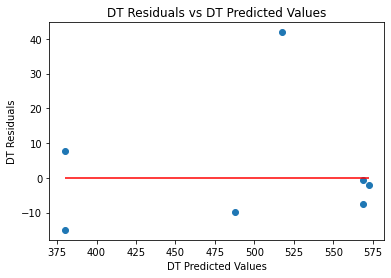

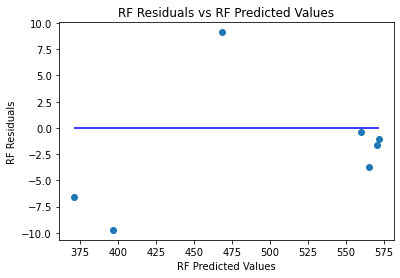

In [10]:
#check and plot residuals - scatter plot of residuals vs. predicted values
import matplotlib.pyplot as plt

#calculate & plot residuals
dt_residuals = y_test - y_pred_best_optimized_dt
rf_residuals = y_test - y_pred_best_optimized_rf

plt.scatter(y_pred_best_optimized_dt, dt_residuals)
plt.xlabel('DT Predicted Values')
plt.ylabel('DT Residuals')
plt.title('DT Residuals vs DT Predicted Values')
plt.hlines(y=0, xmin=y_pred_best_optimized_dt.min(), xmax=y_pred_best_optimized_dt.max(), colors='red')
plt.show()

plt.scatter(y_pred_best_optimized_rf, rf_residuals)
plt.xlabel('RF Predicted Values')
plt.ylabel('RF Residuals')
plt.title('RF Residuals vs RF Predicted Values')
plt.hlines(y=0, xmin=y_pred_best_optimized_rf.min(), xmax=y_pred_best_optimized_rf.max(), colors='blue')
plt.show()

In [11]:
#get feature importances from trained model
feature_importances = dt_model_best_optimized.feature_importances_

#create a DataFrame to display
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

#sort DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)

                                  Feature  Importance
2  Total_Energy_Consumption_Primary_Fuels    0.587348
1          Energy_Renewable_Waste_Sources    0.333764
0                                    Year    0.078888
